<a href="https://colab.research.google.com/github/NSR98/TFT-SkinScanner/blob/master/Modelo_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 32.1MB/s 


In [ ]:
from fastai.vision import *

In [ ]:
np.random.seed(3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = Path("")
base_skin_dir = os.path.join('/content/drive/My Drive/Desarrollo/KAGGLE')
labels = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata_test.csv'), sep=',')
labels.head()

#imageid = {os.path.splitext(os.path.basename(x))[0]: x
                     #for x in glob(os.path.join(path, '*', '*.jpg'))}

labels['path'] = labels['image_id'] +".jpg"
#labels['path'] = labels['path'].str[9:]
labels.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
2019,HAM_0002764,ISIC_0030366,mel,histo,600.0,female,back,ISIC_0030366.jpg
3906,HAM_0001757,ISIC_0025049,nv,histo,650.0,male,lower extremity,ISIC_0025049.jpg
1292,HAM_0003802,ISIC_0032308,mel,histo,750.0,male,face,ISIC_0032308.jpg
939,HAM_0001772,ISIC_0033270,bkl,consensus,850.0,male,back,ISIC_0033270.jpg
966,HAM_0007427,ISIC_0034280,bkl,consensus,600.0,female,back,ISIC_0034280.jpg


In [ ]:
tfms=get_transforms(do_flip=True, flip_vert=True)

In [ ]:
data = ImageDataBunch.from_df(path='/content/drive/My Drive/Desarrollo/KAGGLE/DATASET', 
                              df=labels,
                              ds_tfms=tfms, 
                              size=112, 
                              bs=32,
                              valid_pct=0.2, 
                              fn_col='path', 
                              label_col='dx'
                              ).normalize(imagenet_stats)

In [ ]:
arch = models.densenet121

In [ ]:
learn = cnn_learner(data, arch, metrics= [error_rate, accuracy], callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


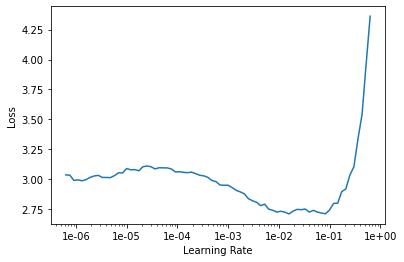

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.908635,1.410214,0.420619,0.579381,36:44
1,1.535007,1.237373,0.412371,0.587629,00:31
2,1.345110,1.261487,0.430928,0.569072,00:26
3,1.198182,1.116789,0.417526,0.582474,00:26
4,1.029480,1.015851,0.383505,0.616495,00:26
5,0.938035,0.951187,0.342268,0.657732,00:26
6,0.851326,0.854178,0.319588,0.680412,00:26
7,0.793549,0.779668,0.300000,0.700000,00:26
8,0.735173,0.777945,0.292783,0.707217,00:26
9,0.661095,0.761256,0.298969,0.701031,00:26


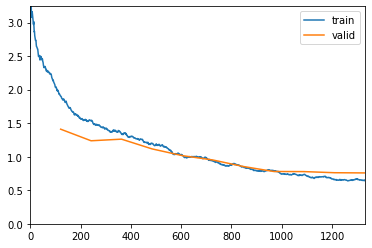

In [ ]:
learn.fit_one_cycle(11, slice(1e-02))

In [ ]:
learn.save("stage1")

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


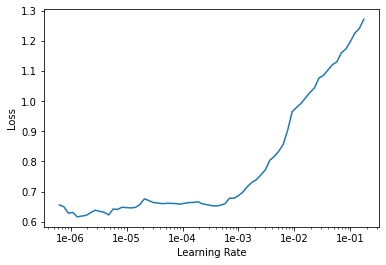

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.681984,0.748809,0.295876,0.704124,00:28
1,0.653843,0.745194,0.271134,0.728866,00:27
2,0.597790,0.737256,0.273196,0.726804,00:28
3,0.583698,0.732457,0.267010,0.732990,00:28
4,0.571191,0.736453,0.269072,0.730928,00:28


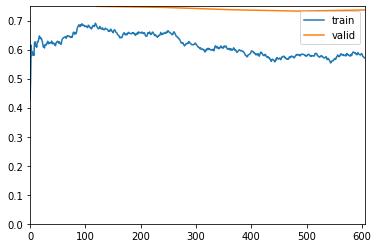

In [ ]:
learn.fit_one_cycle(5, slice(5e-6,5e-4), pct_start=0.05)

In [ ]:
learn.save("stage2")

In [ ]:
data = ImageDataBunch.from_df(path='/content/drive/My Drive/Desarrollo/KAGGLE/DATASET', df=labels,
                              ds_tfms=tfms, size=224,bs=32,
                               valid_pct=0.2, fn_col='path', 
                              label_col='dx'
                              ).normalize(imagenet_stats)

In [ ]:
learn.data = data

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


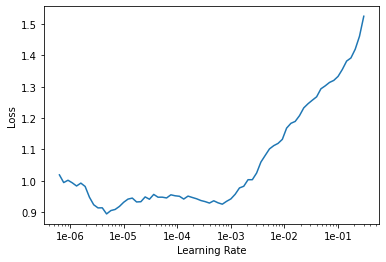

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.924634,0.764923,0.300000,0.700000,00:58
1,0.914523,0.745434,0.280412,0.719588,00:57
2,0.923752,0.725539,0.284536,0.715464,00:56
3,0.874477,0.707178,0.278351,0.721649,00:56
4,0.860265,0.689902,0.267010,0.732990,00:56
5,0.871979,0.693788,0.265979,0.734021,00:55
6,0.849016,0.675143,0.256701,0.743299,00:55
7,0.834319,0.674334,0.257732,0.742268,00:55
8,0.827200,0.667664,0.251546,0.748454,00:55
9,0.823248,0.668200,0.254639,0.745361,00:54


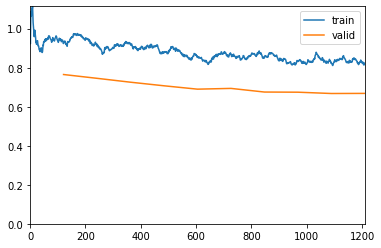

In [ ]:
learn.fit_one_cycle(10,slice(1e-05))

In [ ]:
learn.save("stage3")

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


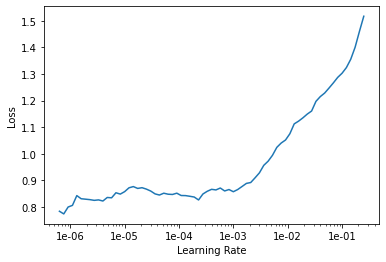

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.801538,0.634957,0.236082,0.763918,00:56
1,0.753748,0.592728,0.215464,0.784536,00:56
2,0.741628,0.574033,0.218557,0.781443,00:55
3,0.742315,0.566205,0.213402,0.786598,00:56
4,0.683862,0.565704,0.218557,0.781443,00:55


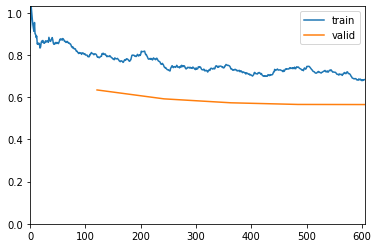

In [ ]:
learn.fit_one_cycle(5, slice(1e-4))

In [ ]:
learn.save("stage4")

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


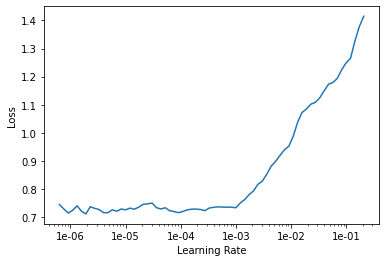

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.689719,0.559358,0.216495,0.783505,00:57
1,0.677129,0.548537,0.197938,0.802062,00:59
2,0.621782,0.529753,0.197938,0.802062,00:59
3,0.604466,0.526179,0.202062,0.797938,00:59
4,0.611580,0.527867,0.195876,0.804124,00:59


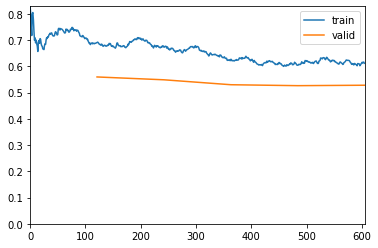

In [ ]:
learn.fit_one_cycle(5, slice(1e-5,1e-4), pct_start=0.05)

In [ ]:
learn.save("stage5")

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


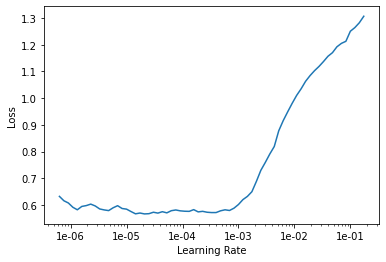

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.600431,0.524093,0.202062,0.797938,00:58
1,0.570673,0.523192,0.194845,0.805155,00:58
2,0.594507,0.522959,0.202062,0.797938,00:59
3,0.574573,0.521031,0.194845,0.805155,00:59
4,0.594728,0.524907,0.192784,0.807216,00:59
5,0.589438,0.510610,0.184536,0.815464,00:59
6,0.568474,0.515639,0.186598,0.813402,00:59
7,0.563932,0.515123,0.186598,0.813402,00:59


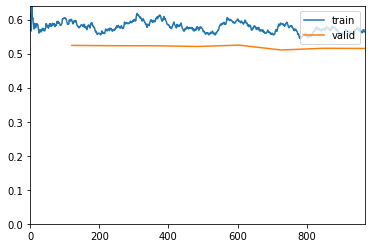

In [ ]:
learn.fit_one_cycle(8, slice(1e-4))

In [ ]:
#Accuracy based on validation set
preds, y , loss = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} % .'.format(acc*100))

The accuracy is 81.34020233154297 % .


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
#losses, idxs = interp.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)

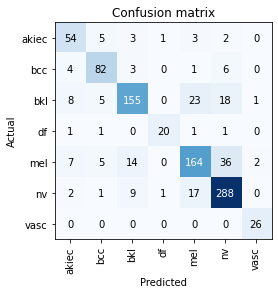

In [ ]:
interp.plot_confusion_matrix()

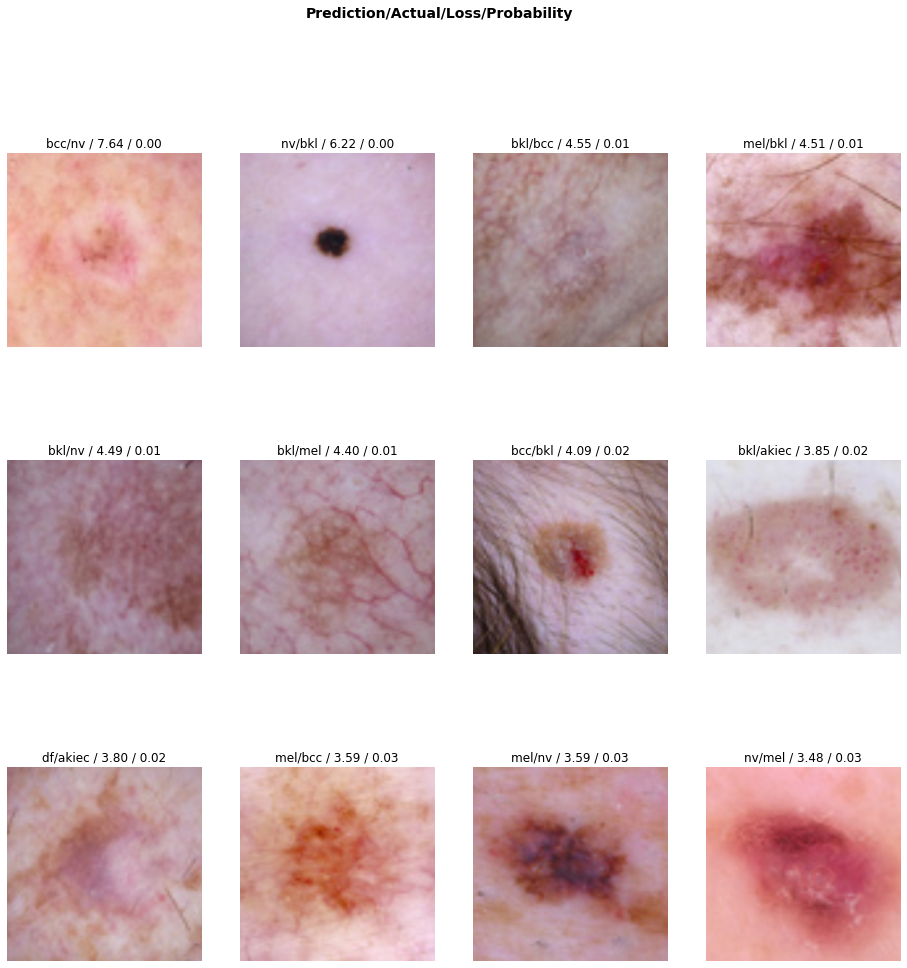

In [ ]:
interp.plot_top_losses(12, figsize=(16,16), heatmap = False)

In [ ]:
interp.most_confused()

[('mel', 'nv', 36),
 ('bkl', 'mel', 23),
 ('bkl', 'nv', 18),
 ('nv', 'mel', 17),
 ('mel', 'bkl', 14),
 ('nv', 'bkl', 9),
 ('bkl', 'akiec', 8),
 ('mel', 'akiec', 7),
 ('bcc', 'nv', 6),
 ('akiec', 'bcc', 5),
 ('bkl', 'bcc', 5),
 ('mel', 'bcc', 5),
 ('bcc', 'akiec', 4),
 ('akiec', 'bkl', 3),
 ('akiec', 'mel', 3),
 ('bcc', 'bkl', 3),
 ('akiec', 'nv', 2),
 ('mel', 'vasc', 2),
 ('nv', 'akiec', 2),
 ('akiec', 'df', 1),
 ('bcc', 'mel', 1),
 ('bkl', 'vasc', 1),
 ('df', 'akiec', 1),
 ('df', 'bcc', 1),
 ('df', 'mel', 1),
 ('df', 'nv', 1),
 ('nv', 'bcc', 1),
 ('nv', 'df', 1)]

In [ ]:
# EXPORTAR
learn.export('/content/drive/My Drive/Desarrollo/KAGGLE/MODELOS/export.pkl')